In [1]:
import warnings
warnings.filterwarnings('ignore')

In [7]:

from typing import List, Optional
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import statsmodels.api as sm
from tqdm import tqdm
import lightgbm as lgb
import catboost as cb
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
import sklearn as sk
from sklearn.metrics import roc_auc_score, f1_score,r2_score,classification_report,accuracy_score,precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import ttest_rel
%matplotlib inline

In [8]:
TRAIN = 'course_project_train.csv'
TEST = 'course_project_test.csv'
Train_working="Train_working.csv"
Test_working ='Test_working.csv'
predict = 'VErshov_predictions.csv'
Train_work = 'Train_work.pkl'
Test_work = 'Test_work.pkl'


In [9]:
train = pd.read_csv(Train_working)
test= pd.read_csv(Test_working)
target = train['Credit Default']
with open(Train_work, 'rb') as f:
    train_work = pickle.load(f)
with open(Test_work, 'rb') as f:
    test_work = pickle.load(f)

# train_ = pd.read_csv(TRAIN)    

In [10]:
for i in ['start','1','2','3']:
    train_work[i] =train_work[i].drop(['Home Ownership','Purpose','Term'],axis=1)
    test_work[i] =test_work[i].drop(['Home Ownership','Purpose','Term'],axis=1)

In [11]:
# разделим признаки по типу
target_col = ['Credit Default']
categorical_features=['Home Ownership','Tax Liens','Purpose','Term']
discrete_feature = ['Years in current job','Number of Open Accounts',\
                    'Years of Credit History','Number of Credit Problems',\
                   'Months since last delinquent','Bankruptcies','Credit Score']
continuous_feature = ['Annual Income','Maximum Open Credit','Current Loan Amount',\
                      'Current Credit Balance','Monthly Debt']
len(target_col + categorical_features +  discrete_feature + continuous_feature)

17

In [12]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) :
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [13]:
def test_hold_out_val(df,target,params,n=50):
    res = pd.DataFrame()
    for j in [0.2,0.25,0.3,0.35]:
        score={}
        score['test'] = []
        score['train'] = []   
        for i in range(n):      
            x_train, x_test,y_train,y_test = train_test_split(df,target, test_size=j,\
                                                              shuffle=True, random_state=i+1)
            dtrain = xgb.DMatrix( data=x_train, label=y_train)
            dvalid = xgb.DMatrix( data=x_test, label=y_test)
            model = xgb.train(
                    params=params,
                    dtrain=dtrain,
                    num_boost_round=10000,
                    early_stopping_rounds=90,
                    evals=[(dtrain, "train"), (dvalid, "valid")],
                    verbose_eval=1000,
                    maximize=True,
                )
            score['train'].append(roc_auc_score(y_train,model.predict(dtrain)))
            score['test'].append(model.best_score)
        test = np.array(score['test'])
        train = np.array(score['train'])
        res.loc[j,'conf_v']=str(calculate_confidence_interval(test))
        res.loc[j,'min_v']=test.min()
        res.loc[j,'max_v']=test.max()
        res.loc[j,'delta_v']=test.max() - test.min()
        res.loc[j,'mean_v']=test.mean()
        res.loc[j,'std_v']=test.std()
        res.loc[j,'delta_mean_v_t']=train.mean()-test.mean()
        res.loc[j,'conf_t']=str(calculate_confidence_interval(train))
        res.loc[j,'min_t']=train.min()
        res.loc[j,'max_t']=train.max()
        res.loc[j,'delta_t']=train.max() - train.min()
        res.loc[j,'mean_t']=train.mean()
        res.loc[j,'std_t']=train.std()
    return res  


def test_cros_val(df,target,model,metric,n=100):
    res = pd.DataFrame()
    for j in [3,4,5,6,7,8]:
        score=[]
        std = []
 
        for i in range(n):
            cv_strategy = KFold(n_splits=j, shuffle=True, random_state=i+1)        
            rusult= make_cross_validation(df, target, model, metric,cv_strategy,print_is=False)
            
            score.append(rusult[1])
            std.append(np.array(rusult[3]).std())

        test = np.array(score)
        train = np.array(std)

        res.loc[j,'conf_of']=str(calculate_confidence_interval(test))
        res.loc[j,'min_of']=test.min()
        res.loc[j,'max_of']=test.max()
        res.loc[j,'delta_of']=test.max() - test.min()
        res.loc[j,'mean_of']=test.mean()
        res.loc[j,'std_of'] = test.std()
        res.loc[j,'conf_st']=str(calculate_confidence_interval(train))
        res.loc[j,'min_st']=train.min()
        res.loc[j,'max_st']=train.max()
        res.loc[j,'delta_st']=train.max() - train.min()
        res.loc[j,'mean_st']=train.mean()
        res.loc[j,'std_st']=train.std()
    return res
        

In [14]:
def drop_target(df,target='Credit Default'):
    return df.drop(target,axis = 1)

In [15]:
def test_for_data(        y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy: int,
                          data: list):
    p,t_stats, n_trees,off_n = [], [],[],[]
    base_score = np.array([])
    for num,i in enumerate(data):
        current_score = np.array([])
        off = []
        
        for j in range(10):
            fold = KFold(n_splits=cv_strategy, shuffle=True, random_state=j)
            res = make_cross_validation(i,y,estimator,metric,fold,print_is=False)
            scores = res[3]
            off.append(res[1])
            if num == 0:
                base_score = np.append(base_score, scores)
            else:
                current_score = np.append(current_score, scores)
        if num!=0:
            t_stat, p_value = ttest_rel(current_score, base_score)
            t_stats.append(t_stat)
            n_trees.append(num)
            p.append(p_value)
        off_n.append(off)

    plt.plot(n_trees, t_stats)
    plt.xlabel('data')
    plt.ylabel('t-statistic')
    return (t_stats,p),off_n
        
        
    
    

def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,print_is = True):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train, \
          eval_set=[(x_train, y_train)],eval_metric = 'auc',verbose=None,early_stopping_rounds=90) 

        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if print_is:
            print(msg)
            print("="*69)
        estimators.append(estimator)
    oof_score = metric(y, oof_predictions)
    if print_is:
        print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
        print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
        print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [25]:
params = {'booster': 'gbtree', 
           'n_estimators': 135,
           "objective": "binary:logistic",   
           'nthread': -1,
           'seed': 28, 
           'learning_rate': 0.05,
            "eval_metric": "auc",
           'max_depth': 4, 
           'reg_lambda': 3, 
           'min_child_weight': 3,
           'gamma':0 }

1. Обучение с применением отложенной выборки. Валидационная Выборка одна

In [26]:
x_train, x_test,y_train,y_test = train_test_split(train_work['6-2'].drop(target_col[0], axis=1),target, test_size=0.2,\
                                                              shuffle=True, random_state=1)

In [27]:
x_train.shape, x_test.shape

((6000, 13), (1500, 13))

In [28]:
dtrain = xgb.DMatrix( data=x_train, label=y_train)
dvalid = xgb.DMatrix( data=x_test, label=y_test)

In [29]:
%%time
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    early_stopping_rounds=90,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

[16:37:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.74837	valid-auc:0.74233
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 90 rounds.
[100]	train-auc:0.81409	valid-auc:0.76692
Stopping. Best iteration:
[104]	train-auc:0.81550	valid-auc:0.76733

Wall time: 998 ms


п.1 но с разными рандомами

In [30]:
res_2=[]
for i in range(100):
   
    x_train, x_valid,y_train,y_valid = train_test_split(drop_target(train_work['6-2']),target, test_size=0.2,\
                                shuffle=True, random_state=np.random.randint(1000))
    
#     print(x_valid.shape,x_test.shape)
    
    model_1 =xgb.XGBClassifier(**params)
    model_1.fit(x_train, y_train, \
        eval_set=[(x_train, y_train),(x_valid,y_valid)],eval_metric = 'auc',verbose=None,early_stopping_rounds=90) 
    y_test_pred = model_1.predict_proba(x_valid)[:,1]
    res_2.append(roc_auc_score(y_valid,y_test_pred))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())

0.7706983310321261 0.01182035412158283 0.7992167541867727 0.7397943838052727


2. Обучение без использования отложенной выборки (одна отложенная выборка)

In [31]:
%%time
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    early_stopping_rounds=90,
    evals=[(dtrain, "train")],
    verbose_eval=100,
    maximize=True,
)

[16:39:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.74837
Will train until train-auc hasn't improved in 90 rounds.
[100]	train-auc:0.81409
[200]	train-auc:0.85351
[300]	train-auc:0.88628
[400]	train-auc:0.90653
[500]	train-auc:0.92297
[600]	train-auc:0.93668
[700]	train-auc:0.94927
[800]	train-auc:0.95652
[900]	train-auc:0.96438
[1000]	train-auc:0.97072
[1100]	train-auc:0.97514
[1200]	train-auc:0.98005
[1300]	train-auc:0.98343
[1400]	train-auc:0.98602
[1500]	train-auc:0.98817
[1600]	train-auc:0.98979
[1700]	train-auc:0.99142
[1800]	train-auc:0.99276
[1900]	train-auc:0.99406
[2000]	train-auc:0.99499
[2100]	train-auc:0.99590
[2200]	train-au

In [32]:
roc_auc_score(y_test,model.predict(dvalid))

0.737325246778219

п.2 но с разными рандомами

In [33]:
res_2=[]
for i in range(100):
   
    x_train, x_valid,y_train,y_valid = train_test_split(drop_target(train_work['6-2']),target, test_size=0.2,\
                                shuffle=True, random_state=np.random.randint(1000))
    
#     print(x_valid.shape,x_test.shape)
    
    model_1 =xgb.XGBClassifier(**params)
    model_1.fit(x_train, y_train, \
        eval_set=[(x_train, y_train)],eval_metric = 'auc',verbose=None,early_stopping_rounds=90) 
    y_test_pred = model_1.predict_proba(x_valid)[:,1]
    res_2.append(roc_auc_score(y_valid,y_test_pred))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())

0.7728509095407391 0.010548665140751463 0.7966586822780609 0.7495811860634571


3/ Валидация с использованием двух отложенных выборок. Первая учавствует в обучении, вторая на валидации

In [35]:
x_train, x_valid,y_train,y_valid = train_test_split(drop_target(train_work['5']),target, test_size=0.3,\
                                                              shuffle=True, random_state=100)

In [36]:
x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=100)

In [37]:
x_train.shape,x_valid.shape,x_test.shape

((5250, 16), (1125, 16), (1125, 16))

In [38]:
dtrain = xgb.DMatrix( data=x_train, label=y_train)
dvalid = xgb.DMatrix( data=x_valid, label=y_valid)
dtest =  xgb.DMatrix( data = x_test,label=y_test)

In [39]:
%%time
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    early_stopping_rounds=90,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

[16:41:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.74916	valid-auc:0.77249
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 90 rounds.
[100]	train-auc:0.81577	valid-auc:0.80275
Stopping. Best iteration:
[101]	train-auc:0.81598	valid-auc:0.80294

Wall time: 908 ms


In [40]:
roc_auc_score(y_test,model.predict(dtest))

0.7515312122924653

п.3 на разныйх рандомах

In [41]:
res_2 = []
for i in range(100):
   
    x_train, x_valid,y_train,y_valid = train_test_split(drop_target(train_work['6-2']),target, test_size=0.3,\
                                            shuffle=True, random_state=np.random.randint(1000))
    x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                            shuffle=True, random_state=np.random.randint(1000))
#     print(x_valid.shape,x_test.shape)

    model_1 =xgb.XGBClassifier(**params)
    model_1.fit(x_train, y_train, \
          eval_set=[(x_train, y_train),(x_valid,y_valid)],eval_metric = 'auc',verbose=None) 
    y_test_pred = model_1.predict_proba(x_test)[:,1]
    a = roc_auc_score(y_test,y_test_pred)
    res_2.append(a)
#     print(a,roc_auc_score(y_valid,model_1.predict_proba(x_valid)[:,1]))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())

0.7699457416532012 0.014853722245374448 0.8079252492593766 0.731802819545931


Крос валидация

In [16]:
# params = {'booster': 'gbtree', 
#            'n_estimators': 135,
#            "objective": "binary:logistic",   
#            'nthread': -1,
#            'seed': 28, 
#            'learning_rate': 0.05,
#             "eval_metric": "auc",
#            'max_depth': 4, 
#            'reg_lambda': 3, 
#            'min_child_weight': 3,
#            'gamma':0 }

model_sk=xgb.XGBClassifier(**params)

In [42]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=5)

In [43]:
model_sk=xgb.XGBClassifier(**params)


In [44]:
%%time
res = make_cross_validation(
    drop_target(train_work['6']), target, model_sk, metric=roc_auc_score, cv_strategy=cv_strategy
            )

Fold: 1, train-observations = 6000, valid-observations = 1500
train-score = 0.8246, valid-score = 0.7869
Fold: 2, train-observations = 6000, valid-observations = 1500
train-score = 0.8274, valid-score = 0.7733
Fold: 3, train-observations = 6000, valid-observations = 1500
train-score = 0.8254, valid-score = 0.7838
Fold: 4, train-observations = 6000, valid-observations = 1500
train-score = 0.8281, valid-score = 0.7551
Fold: 5, train-observations = 6000, valid-observations = 1500
train-score = 0.8276, valid-score = 0.7738
CV-results train: 0.8266 +/- 0.001
CV-results valid: 0.7746 +/- 0.011
OOF-score = 0.7743
Wall time: 2.24 s


на разных рандомах

In [45]:
%%time
n = 100
res_all=[]
for i in tqdm(range(n)):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    res = make_cross_validation(
    drop_target(train_work['3-3']), target, model_sk, metric=roc_auc_score,\
        cv_strategy=fold,print_is=False
            )
    res_all.append(res[1])
a = np.array(res_all) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]

0.7725847984108557 0.0016304301108721081 0.7762644570973345 0.7683119279547237
Wall time: 2min 50s


<BarContainer object of 13 artists>

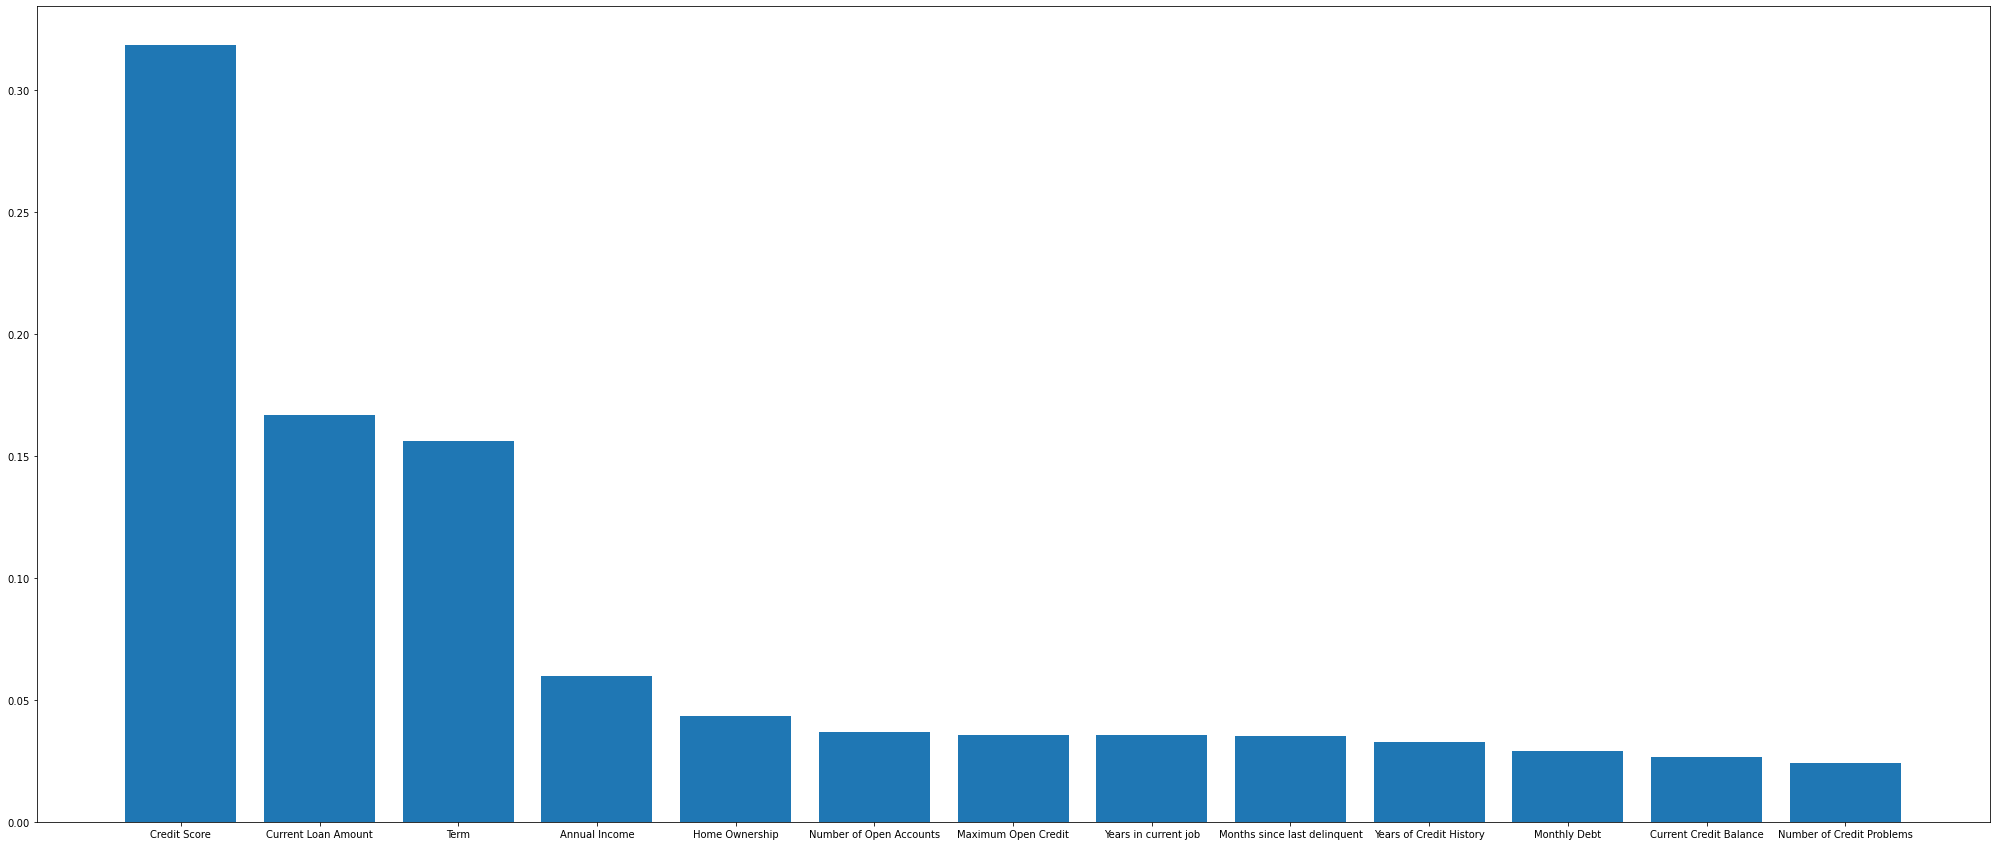

In [1468]:
model_sk.fit(drop_target(train_work['6-2']), target, \
        eval_set=[(drop_target(train_work['6-2']), target)],eval_metric = 'auc',verbose=None,early_stopping_rounds=90) 
model_sk.feature_importances_
d = list(zip(drop_target(train_work['6-2']).columns.to_list(),model_sk.feature_importances_))
x = list(map(lambda x:x[0],(sorted(d,key = lambda x: x[1],reverse=True))))
y = list(map(lambda x:x[1],(sorted(d,key = lambda x: x[1],reverse=True))))
fig = plt.figure(figsize=(35,15))
plt.bar(x[:],y[:])
    

In [803]:
model_sk.feature_importances_

array([0.04030724, 0.04980101, 0.03391216, 0.02986884, 0.03154182,
       0.03477522, 0.03123695, 0.03237543, 0.15590008, 0.1128346 ,
       0.02889119, 0.03042331, 0.38813215], dtype=float32)

In [1460]:
d = []
for n,i in train_work.items():
    k=i.copy()
    
    if n not in ['start','1','2','3']:
        print(n)
        d.append(drop_target(k))

1-1
1-2
1-3
2-1
2-2
2-3
3-1
3-2
3-3
4
5
6
4-2
5-2
6-2


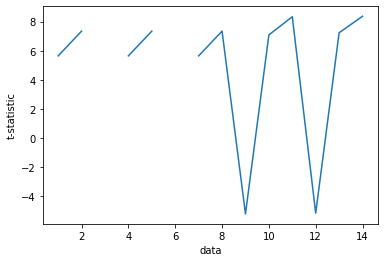

In [391]:
a =  test_for_data(target,model_sk,roc_auc_score,5,d)                     

In [392]:
a[0]

([5.6424783930253355,
  7.343903625130581,
  nan,
  5.6424783930253355,
  7.343903625130581,
  nan,
  5.6424783930253355,
  7.343903625130581,
  -5.222700549380924,
  7.083096400234436,
  8.333541511786546,
  -5.1732422027861364,
  7.231074670618631,
  8.367563453540132],
 [8.27889328703445e-07,
  1.948805988355171e-09,
  nan,
  8.27889328703445e-07,
  1.948805988355171e-09,
  nan,
  8.27889328703445e-07,
  1.948805988355171e-09,
  3.58891003343293e-06,
  4.93272144318283e-09,
  5.930910501350089e-11,
  4.259310663856484e-06,
  2.911615235557205e-09,
  5.2664388582390704e-11])

In [1461]:
d=[]
for i in ['6-2','5-2','6','5','1-3','2-3','3-3']:
    k=train_work[i].copy()
    d.append(drop_target(k))

In [1463]:
%%time
base_score = np.array([])
model = xgb.XGBClassifier(**params)

for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores = cross_val_score(
        estimator=model,
        X=drop_target(train_work['6-2']),
        y=target,
        scoring='roc_auc',
        cv=fold
    )
    print(scores)
    base_score = np.append(base_score, scores)

[0.76129141 0.77823646 0.78680561 0.7684351  0.75886625]
[0.76507504 0.75777058 0.75692205 0.78829718 0.77937982]
[0.75138941 0.7812264  0.75992931 0.79813284 0.78364785]
[0.76793527 0.7645976  0.74708059 0.79033269 0.78574147]
[0.77163867 0.74457288 0.78721534 0.77398369 0.77927169]
[0.78345147 0.77506041 0.78013234 0.74951591 0.77535036]
[0.77630488 0.77489726 0.76198005 0.77676636 0.76917243]
[0.77246395 0.77847434 0.76671158 0.77562635 0.75915526]
[0.77820954 0.78056996 0.76099395 0.77019865 0.77111015]
[0.7765546  0.76795358 0.79083576 0.75383517 0.76697244]
Wall time: 6.32 s


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

1-1
1-2
1-3
2-1
2-2
2-3
3-1
3-2
3-3
4
5
6
4-2
5-2
6-2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:52<00:00,  3.50s/it]


Text(0, 0.5, 't-statistic')

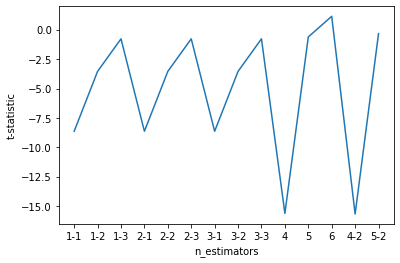

In [1464]:
d = []

for n,i in train_work.items():
    k=i.copy()    
    if n not in ['start','1','2','3']:
        print(n)
        d.append((n,k))
t_stats, n_trees = [], []
j = 1
for data in tqdm(d):
    current_score = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores = cross_val_score(
            estimator=xgb.XGBClassifier(**params),
            X=drop_target(data[1]),
            y=target,
            scoring='roc_auc',
            cv=fold,
            n_jobs=-1
        )
        current_score = np.append(current_score, scores)

    t_stat, p_value = ttest_rel(current_score, base_score)
    t_stats.append(t_stat)
    n_trees.append(data[0])

plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

In [1465]:
t_stats

[-8.634326010059501,
 -3.541998973886593,
 -0.7740641453610144,
 -8.634326010059501,
 -3.541998973886593,
 -0.7740641453610144,
 -8.634326010059501,
 -3.541998973886593,
 -0.7740641453610144,
 -15.622503269156653,
 -0.6148732962023529,
 1.1389075624789453,
 -15.672597524440866,
 -0.33515570869650735,
 nan]

In [1466]:
n_trees

['1-1',
 '1-2',
 '1-3',
 '2-1',
 '2-2',
 '2-3',
 '3-1',
 '3-2',
 '3-3',
 '4',
 '5',
 '6',
 '4-2',
 '5-2',
 '6-2']

Балансировка признаков

In [1481]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [1482]:
x_train, x_valid,y_train,y_valid = train_test_split(train_work['6'],target, test_size=0.3,\
                                                              shuffle=True, random_state=89)

In [1483]:
x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=89)

In [1484]:
train_balanced = balance_df_by_target(x_train, target_col[0])

In [1485]:
target_balanced = train_balanced[target_col[0]]

In [1486]:
res2 = make_cross_validation(
    drop_target(train_balanced), target_balanced, model_sk, metric=roc_auc_score, cv_strategy=cv_strategy
            )

Fold: 1, train-observations = 5353, valid-observations = 1339
train-score = 0.8194, valid-score = 0.7765
Fold: 2, train-observations = 5353, valid-observations = 1339
train-score = 0.811, valid-score = 0.7947
Fold: 3, train-observations = 5354, valid-observations = 1338
train-score = 0.8192, valid-score = 0.7911
Fold: 4, train-observations = 5354, valid-observations = 1338
train-score = 0.8162, valid-score = 0.7783
Fold: 5, train-observations = 5354, valid-observations = 1338
train-score = 0.8243, valid-score = 0.7704
CV-results train: 0.818 +/- 0.004
CV-results valid: 0.7822 +/- 0.009
OOF-score = 0.7818


Обучим на сбалансированной, с учетом валидации первой отложенной выборки и контроля на второй отложенной выборке

In [1487]:
model_sk.fit(drop_target(train_balanced), target_balanced, \
          eval_set=[(drop_target(train_balanced), target_balanced),(drop_target(x_valid),y_valid)],eval_metric = 'auc',verbose=None) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=3, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=15,
              nthread=15, num_parallel_tree=1, random_state=27, reg_alpha=0,
              reg_lambda=5, scale_pos_weight=1, seed=27, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1488]:
model_sk.best_score

0.824282

In [1489]:
y_test_pred = model_sk.predict_proba(drop_target(x_test))[:,1]

In [1490]:
roc_auc_score(y_test,y_test_pred)

0.7849163879598662

In [1493]:

res_2 = []
for i in range(100):
   
    x_train, x_valid,y_train,y_valid = train_test_split(train_work['6'],target, test_size=0.3,\
                                                              shuffle=True, random_state=np.random.randint(1000))
    x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=np.random.randint(1000))
#     print(x_valid.shape,x_test.shape)
    train_balanced = balance_df_by_target(x_train, target_col[0])
    target_balanced = train_balanced[target_col[0]]
    model_1 =xgb.XGBClassifier(**params)
    model_1.fit(drop_target(train_balanced), target_balanced, \
          eval_set=[(drop_target(train_balanced), target_balanced),\
                    (drop_target(x_valid),y_valid)],eval_metric = 'auc',verbose=None,early_stopping_rounds=90) 
    y_test_pred = model_1.predict_proba(drop_target(x_test))[:,1]
    res_2.append(roc_auc_score(y_test,y_test_pred))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())

0.7690527297917612 0.015308337558572213 0.7973332904170657 0.7294932260600177


Adversarial validation

In [1494]:
a = drop_target(train_work['6-2'])
b = test_work['6-2'].copy()

x_adv = pd.concat([
    a, b], axis=0
)
y_adv = np.hstack((np.zeros(train.shape[0]), np.ones(test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]
x_adv = x_adv.reset_index(drop=True)
# x_adv[categorical_features]=x_adv[categorical_features].astype('category')

In [1496]:
p = {
    "booster": "gbtree",
    'n_estimators':50,
#     "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 25,
    "max_depth": 10,
    "gamma": 0,
    "nthread": 20,
    "seed": 28,

}

In [1497]:
m = xgb.XGBClassifier(**p)

In [1498]:
m.fit(x_adv,y_adv,eval_set=[(x_adv, y_adv)],eval_metric = 'auc',verbose=None,early_stopping_rounds=90)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=20, nthread=20,
              num_parallel_tree=1, random_state=28, reg_alpha=0, reg_lambda=25,
              scale_pos_weight=1, seed=28, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [1502]:
y_pred_adv = m.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.8865


In [1503]:
y_pred = m.predict_proba(drop_target(train_work['6-2']))

In [1504]:
y_pred=y_pred[:, 1]
y_pred

array([0.1412345 , 0.2368795 , 0.20312312, ..., 0.22391064, 0.13720535,
       0.2443741 ], dtype=float32)

In [1505]:
pd.cut(
    y_pred, bins=np.arange(0, 1.01, 0.05)
).value_counts().sort_index()

(0.0, 0.05]       0
(0.05, 0.1]       0
(0.1, 0.15]     158
(0.15, 0.2]    1791
(0.2, 0.25]    3396
(0.25, 0.3]    1680
(0.3, 0.35]     406
(0.35, 0.4]      54
(0.4, 0.45]      13
(0.45, 0.5]       2
(0.5, 0.55]       0
(0.55, 0.6]       0
(0.6, 0.65]       0
(0.65, 0.7]       0
(0.7, 0.75]       0
(0.75, 0.8]       0
(0.8, 0.85]       0
(0.85, 0.9]       0
(0.9, 0.95]       0
(0.95, 1.0]       0
dtype: int64

In [1506]:
idx_val= np.where(y_pred>0.25)
idx_tr = np.where(y_pred<=0.25)

In [1507]:
X_valid = train_work['6-2'].loc[idx_val]
X_train = train_work['6-2'].loc[idx_tr]

Y_valid = X_valid[target_col[0]]
Y_train = X_train[target_col[0]]

X_valid = drop_target(X_valid)
X_train = drop_target(X_train)

In [1508]:
m.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_valid,Y_valid)],eval_metric = 'auc',verbose=None)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=20, nthread=20,
              num_parallel_tree=1, random_state=28, reg_alpha=0, reg_lambda=25,
              scale_pos_weight=1, seed=28, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [1509]:
model_sk.best_score

0.759165

In [1510]:
roc_auc_score(Y_valid,model_sk.predict_proba(X_valid)[0:,1])

0.6022457497122549

In [1511]:
X_train.shape,X_valid.shape

((5345, 13), (2155, 13))

In [1512]:
model_sk.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=3, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=15,
              nthread=15, num_parallel_tree=1, random_state=27, reg_alpha=0,
              reg_lambda=5, scale_pos_weight=1, seed=27, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

In [1513]:
param = {
    "booster": "gbtree",
    'n_estimators':1000,
#     "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.05,
    "reg_lambda": 50,
    "max_depth": 6,
    "gamma": 4,
    "nthread": 15,
    "seed": 28,
}



In [ ]:
{'booster': 'gbtree',
   'objective': 'binary:logistic',
   'nthread': 15,
   'seed': 28,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'max_depth': 8,
   'reg_lambda': 40,
   'min_child_weight': 20,
   'n_estimators': 600,
   'gamma': 10},

In [1028]:
learning_rate=[0.05,0.1] 
reg_lambda =[10,20,30] 
max_depth = [2,4,6,8,10]
gamma = [10,20,40]
min_child_weight = [20,30,40,50]
# colsample_bytre = [0.1,0.2,0.,0.4,0.5,0.6,0.7,0.8,0.9]
n_estimators = [300,500,800]
result = []
i = 1
param = {
    "booster": "gbtree",
    "objective": "binary:logistic", 
    "nthread": 15,
    "seed": 28,
    "eval_metric": "auc",
}

for g in tqdm(gamma):
    for r in reg_lambda:
        for l in  learning_rate:
            for m in max_depth:
                for mi in min_child_weight:
                    for n  in n_estimators:
                        param['learning_rate'] = l
                        param['max_depth'] = m
                        param['reg_lambda'] = r
                        param['min_child_weight'] = mi
                        param['n_estimators'] = n
                        param['gamma'] = g
                        mod = xgb.XGBClassifier(**param)
                        res = make_cross_validation(drop_target(train_work['6-2']),\
                        target, mod, metric=roc_auc_score, cv_strategy=cv_strategy,print_is=False)
                        print(i,param,res[1])
                        result.append((i,param,res[1]))
                        i+=1

                        
                        

   
    
    

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 10} 0.7645319475616176
2 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 10} 0.7645319475616176
3 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 10} 0.7645319475616176
4 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 10} 0.7628584475904772
5 {'booster': 'gbtree', 'objective': 'binary

36 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 10} 0.759330823156587
37 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 10} 0.7668599477577043
38 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 10} 0.7668599477577043
39 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 10} 0.7668599477577043
40 {'booster': 'gbtree', 'objective': 'bi

71 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 10} 0.7602467720619946
72 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 10} 0.7602467720619946
73 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 10} 0.7662222712633726
74 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 10} 0.7662222712633726
75 {'booster': 'gbtree', 'objective': 'binar

106 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 10} 0.7607313657855921
107 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 10} 0.7607313657855921
108 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 10} 0.7607313657855921
109 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 10} 0.7678494291044917
110 {'booster': 'gbtree', 'objective': 

141 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 10} 0.7621493910380559
142 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 10} 0.7601968719106161
143 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 10} 0.7601968719106161
144 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 10} 0.7601968719106161
145 {'booster': 'gbtree', 'objective

175 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 10} 0.7624286298253029
176 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 10} 0.7624286298253029
177 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 10} 0.7624286298253029
178 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 10} 0.7594616792753865
179 {'booster': 'gbtree', 'objec

210 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 10} 0.7643826424431888
211 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 10} 0.7640441032999902
212 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 10} 0.7640441032999902
213 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 10} 0.7640441032999902
214 {'booster': 'gbtree', 'objective': '

245 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 10} 0.762046779459165
246 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 10} 0.762046779459165
247 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 10} 0.7611705837553395
248 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 10} 0.7611705837553395
249 {'booster': 'gbtree', 'objective':

280 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 10} 0.7641848867376378
281 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 10} 0.7641848867376378
282 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 10} 0.7641848867376378
283 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 10} 0.7620432214378079
284 {'booster': 'gbtree', 'objective

314 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 10} 0.7660613257047013
315 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 10} 0.7660613257047013
316 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 10} 0.7634128400293392
317 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 10} 0.7634128400293392
318 {'booster': 'gbtree', 'objective': '

349 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 10} 0.7653776145636754
350 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 10} 0.7653776145636754
351 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 10} 0.7653776145636754
352 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 10} 0.7644380333682664
353 {'booster': 'gbtree', 'objective

 33%|███████████████████████████▋                                                       | 1/3 [14:02<28:05, 842.78s/it]

360 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 10} 0.760513008697122
361 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 20} 0.7578877160498654
362 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 20} 0.7578877160498654
363 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 20} 0.7578877160498654
364 {'booster': 'gbtree', 'objective'

395 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 20} 0.7508602724600977
396 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 20} 0.7508602724600977
397 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 20} 0.7569494965663337
398 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 20} 0.7569494965663337
399 {'booster': 'gbtree', 'objective

430 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 20} 0.7541771390363174
431 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 20} 0.7541771390363174
432 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 20} 0.7541771390363174
433 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 20} 0.7585679130957237
434 {'booster': 'gbtree', 'objective': '

465 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 20} 0.7552389668173657
466 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 20} 0.7493202202529429
467 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 20} 0.7493202202529429
468 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 20} 0.7493202202529429
469 {'booster': 'gbtree', 'objective': '

500 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 20} 0.7557098116436204
501 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 20} 0.7557098116436204
502 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 20} 0.7480901990919402
503 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 20} 0.7480901990919402
504 {'booster': 'gbtree', 'objective

534 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 20} 0.7556577591089519
535 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 20} 0.7520836168402819
536 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 20} 0.7520836168402819
537 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 20} 0.7520836168402819
538 {'booster': 'gbtree', 'objec

569 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 20} 0.7566722783838079
570 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 20} 0.7566722783838079
571 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 20} 0.7529051244380631
572 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 20} 0.7529051244380631
573 {'booster': 'gbtree', 'objective': '

604 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 20} 0.7562312594402872
605 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 20} 0.7562312594402872
606 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 20} 0.7562312594402872
607 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 20} 0.7542222951592197
608 {'booster': 'gbtree', 'objective

639 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 20} 0.7516401380301441
640 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 20} 0.751370079816522
641 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 20} 0.751370079816522
642 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 20} 0.751370079816522
643 {'booster': 'gbtree', 'objective': 

674 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 20} 0.7563932153013191
675 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 20} 0.7563932153013191
676 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 20} 0.7554235007398489
677 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 20} 0.7554235007398489
678 {'booster': 'gbtree', 'objective': '

709 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 20} 0.7523956684911556
710 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 20} 0.7523956684911556
711 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 20} 0.7523956684911556
712 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 20} 0.7510409408778966
713 {'booster': 'gbtree', 'objective

 67%|███████████████████████████████████████████████████████▎                           | 2/3 [25:39<13:18, 798.94s/it]

720 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 20} 0.7521011433899298
721 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 40} 0.7528403772346022
722 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 40} 0.7528403772346022
723 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 40} 0.7528403772346022
724 {'booster': 'gbtree', 'objective

755 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 40} 0.7512600007854003
756 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 40} 0.7512600007854003
757 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 40} 0.7519917671778416
758 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 40} 0.7519917671778416
759 {'booster': 'gbtree', 'objective

789 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 40} 0.7523534993491456
790 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 40} 0.7508434926556729
791 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 40} 0.7508434926556729
792 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 40} 0.7508434926556729
793 {'booster': 'gbtree', 'objective': '

824 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 40} 0.7469071789538029
825 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 40} 0.7469071789538029
826 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 40} 0.7495893120903937
827 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 40} 0.7495893120903937
828 {'booster': 'gbtree', 'objective': '

859 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 40} 0.7466569753778772
860 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 40} 0.7466569753778772
861 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 40} 0.7466569753778772
862 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 40} 0.7480639312305633
863 {'booster': 'gbtree', 'objective

894 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 40} 0.7482425351174512
895 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 40} 0.7464382229537007
896 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 40} 0.7464382229537007
897 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 800, 'gamma': 40} 0.7464382229537007
898 {'booster': 'gbtree', 'objec

929 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 40} 0.7512600007854002
930 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 40} 0.7512600007854002
931 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 40} 0.7494240178389527
932 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 20, 'min_child_weight': 40, 'n_estimators': 500, 'gamma': 40} 0.7494240178389527
933 {'booster': 'gbtree', 'objective': '

964 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 40} 0.7526138938010571
965 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 40} 0.7526138938010571
966 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 800, 'gamma': 40} 0.7526138938010571
967 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 40, 'n_estimators': 300, 'gamma': 40} 0.7533741682905447
968 {'booster': 'gbtree', 'objective

998 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 40} 0.7521478808556575
999 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 40} 0.7521478808556575
1000 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 300, 'gamma': 40} 0.7521478808556575
1001 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 30, 'n_estimators': 500, 'gamma': 40} 0.7521478808556575
1002 {'booster': 'gbtree', 'object

1032 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 30, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 40} 0.7471448196395047
1033 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 40} 0.7509868238123171
1034 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 500, 'gamma': 40} 0.7509868238123171
1035 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 800, 'gamma': 40} 0.7509868238123171
1036 {'booster': 'gbtree', 'objectiv

1066 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 50, 'n_estimators': 300, 'gamma': 40} 0.7485304273640482
1067 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 50, 'n_estimators': 500, 'gamma': 40} 0.7485304273640482
1068 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 30, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 40} 0.7485304273640482
1069 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 20, 'n_estimators': 300, 'gamma': 40} 0.7509868238123171
1070 {'booster': 'gbtree', 'objecti

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [35:55<00:00, 718.64s/it]

1080 {'booster': 'gbtree', 'objective': 'binary:logistic', 'nthread': 15, 'seed': 28, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 30, 'min_child_weight': 50, 'n_estimators': 800, 'gamma': 40} 0.7485304273640482


In [1029]:
with open('tun_param_xgb_7.pk','wb') as f:
    pickle.dump(result,f)

In [1030]:
result.sort(key = lambda x: x[2],reverse=True)
result

[(97,
  {'booster': 'gbtree',
   'objective': 'binary:logistic',
   'nthread': 15,
   'seed': 28,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'max_depth': 10,
   'reg_lambda': 30,
   'min_child_weight': 50,
   'n_estimators': 800,
   'gamma': 40},
  0.7681984226808136),
 (98,
  {'booster': 'gbtree',
   'objective': 'binary:logistic',
   'nthread': 15,
   'seed': 28,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'max_depth': 10,
   'reg_lambda': 30,
   'min_child_weight': 50,
   'n_estimators': 800,
   'gamma': 40},
  0.7681984226808136),
 (99,
  {'booster': 'gbtree',
   'objective': 'binary:logistic',
   'nthread': 15,
   'seed': 28,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'max_depth': 10,
   'reg_lambda': 30,
   'min_child_weight': 50,
   'n_estimators': 800,
   'gamma': 40},
  0.7681984226808136),
 (109,
  {'booster': 'gbtree',
   'objective': 'binary:logistic',
   'nthread': 15,
   'seed': 28,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'max_dep

In [1008]:
with open('tun_param_xgb','rb') as f:
    res1 =  pickle.load(f)
with open('tun_param_xgb_1.pk','rb') as f:
    res2 =  pickle.load(f) 
with open('tun_param_xgb_2.pk','rb') as f:
    res3 =  pickle.load(f)
with open('tun_param_xgb_3.pk','rb') as f:
    res4 =  pickle.load(f)   
    
res_all = res1 + res2 + res3 + res4
res_all.sort(key = lambda x: x[2],reverse=True)
res_all

[(98,
  {'booster': 'gbtree',
   'objective': 'binary:logistic',
   'nthread': 15,
   'seed': 28,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'max_depth': 8,
   'reg_lambda': 40,
   'min_child_weight': 20,
   'n_estimators': 600,
   'gamma': 10},
  0.7753672207486937),
 (99,
  {'booster': 'gbtree',
   'objective': 'binary:logistic',
   'nthread': 15,
   'seed': 28,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'max_depth': 8,
   'reg_lambda': 40,
   'min_child_weight': 20,
   'n_estimators': 600,
   'gamma': 10},
  0.7753672207486937),
 (100,
  {'booster': 'gbtree',
   'objective': 'binary:logistic',
   'nthread': 15,
   'seed': 28,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'max_depth': 8,
   'reg_lambda': 40,
   'min_child_weight': 20,
   'n_estimators': 600,
   'gamma': 10},
  0.7753672207486937),
 (3976,
  {'booster': 'gbtree',
   'n_estimators': 50,
   'eval_metric': 'auc',
   'learning_rate': 0.1,
   'reg_lambda': 25,
   'max_depth': 10,
   'gamma': 0,
 